In [ ]:
# 导入包含辅助函数的python文件
%%bash
git clone https://github.com/XiwangLi/object-tracking-SORT-Pytorch.git

Cloning into 'object-tracking-SORT-Pytorch'...


In [ ]:
cd object-tracking-SORT-Pytorch

/content/object-tracking-SORT-Pytorch


In [ ]:
cp utils/datasets.py ../

In [ ]:
cp models.py ../


In [ ]:
cp sort.py ../

In [ ]:
#downloading yolo weight
!wget https://pjreddie.com/media/files/yolov3.weights  -O config/yolov3.weights

--2020-09-11 04:39:34--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘config/yolov3.weights’

config/yolov3.weigh 100%[===================>] 236.52M   647KB/s    in 6m 24s  

2020-09-11 04:45:58 (631 KB/s) - ‘config/yolov3.weights’ saved [248007048/248007048]



In [ ]:
pip install filterpy

     |████████████████████████████████| 184kB 3.4MB/s 
  Created wheel for filterpy: filename=filterpy-1.4.5-cp36-none-any.whl size=110450 sha256=5ee9f17cd154598e19707bd261b43ae91b0c50e01f52c9babec69de9af7a7d4c
  Stored in directory: /root/.cache/pip/wheels/c3/0c/dd/e92392c3f38a41371602d99fc77d6c1d42aadbf0c6afccdd02
Successfully built filterpy


In [ ]:
from models import *
from utils import *
import os, sys, time, datetime, random
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
# initialize Sort object and video capture
from sort import *

import cv2
from IPython.display import clear_output

In [ ]:
config_path = '/content/object-tracking-SORT-Pytorch/config/yolov3.cfg'
weights_path = '/content/object-tracking-SORT-Pytorch/config/yolov3.weights'
class_path = '/content/object-tracking-SORT-Pytorch/config/coco.names'
img_size = 416
conf_thres = 0.8
nms_thres = 0.4


In [ ]:
# Darknet网络构造
model = Darknet(config_path, img_size=img_size)
model

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [ ]:
# 加载权重
model.load_weights(weights_path)
# 使用GPU处理数据
model.cuda()
# 固定模型BN层和dropout层,不改变模型权值,调用模型进行预测
model.eval()

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [ ]:
classes = utils.load_classes(class_path)
# 可检测的物体类别数
print("可检测的物体类别数 ",len(classes))
print("前5类物体 ",classes[:5])

可检测的物体类别数  80
前5类物体  ['person', 'bicycle', 'car', 'motorbike', 'aeroplane']


In [ ]:
Tensor = torch.cuda.FloatTensor

In [ ]:
def detect_image(img):
    # scale and pad image
    ratio = min(img_size/img.size[0], img_size/img.size[1])
    imw = round(img.size[0] * ratio)
    imh = round(img.size[1] * ratio)
    img_transforms = transforms.Compose([ transforms.Resize((imh, imw)),
         transforms.Pad((max(int((imh-imw)/2),0), max(int((imw-imh)/2),0), max(int((imh-imw)/2),0), max(int((imw-imh)/2),0)),
                        (128,128,128)),
         transforms.ToTensor(),
         ])
    # convert image to Tensor
    image_tensor = img_transforms(img).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input_img = Variable(image_tensor.type(Tensor))
    # run inference on the model and get detections
    with torch.no_grad():
        detections = model(input_img)
        detections = utils.non_max_suppression(detections, 80, conf_thres, nms_thres)
    return detections[0]

In [ ]:
def convertMillis(millseconds):
    seconds, millseconds = divmod(millseconds, 1000)
    minutes, seconds = divmod(seconds, 60)
    hours, minutes = divmod(minutes, 60)
    day, hours = divmod(hours, 24)
    seconds = int(seconds + millseconds/10000)
    return f"{int(hours)}:{int(minutes)}:{int(seconds)}"

In [ ]:
# 读取视频数据
videopath = '/content/Tennis.mp4'
%pylab inline 
cmap = plt.get_cmap('tab20b')
cmap

Populating the interactive namespace from numpy and matplotlib


In [ ]:
colors = [cmap(i)[:3] for i in np.linspace(0, 1, 20)]
print("候选框颜色种类 ",len(colors))

候选框颜色种类  20


In [ ]:
# initialize Sort object and video capture
cap = cv2.VideoCapture(videopath)
mot_tracker = Sort() 

In [ ]:
timestamp = cap.get(cv2.CAP_PROP_POS_MSEC)
time_report = convertMillis(timestamp)
time_report

'0:0:0'

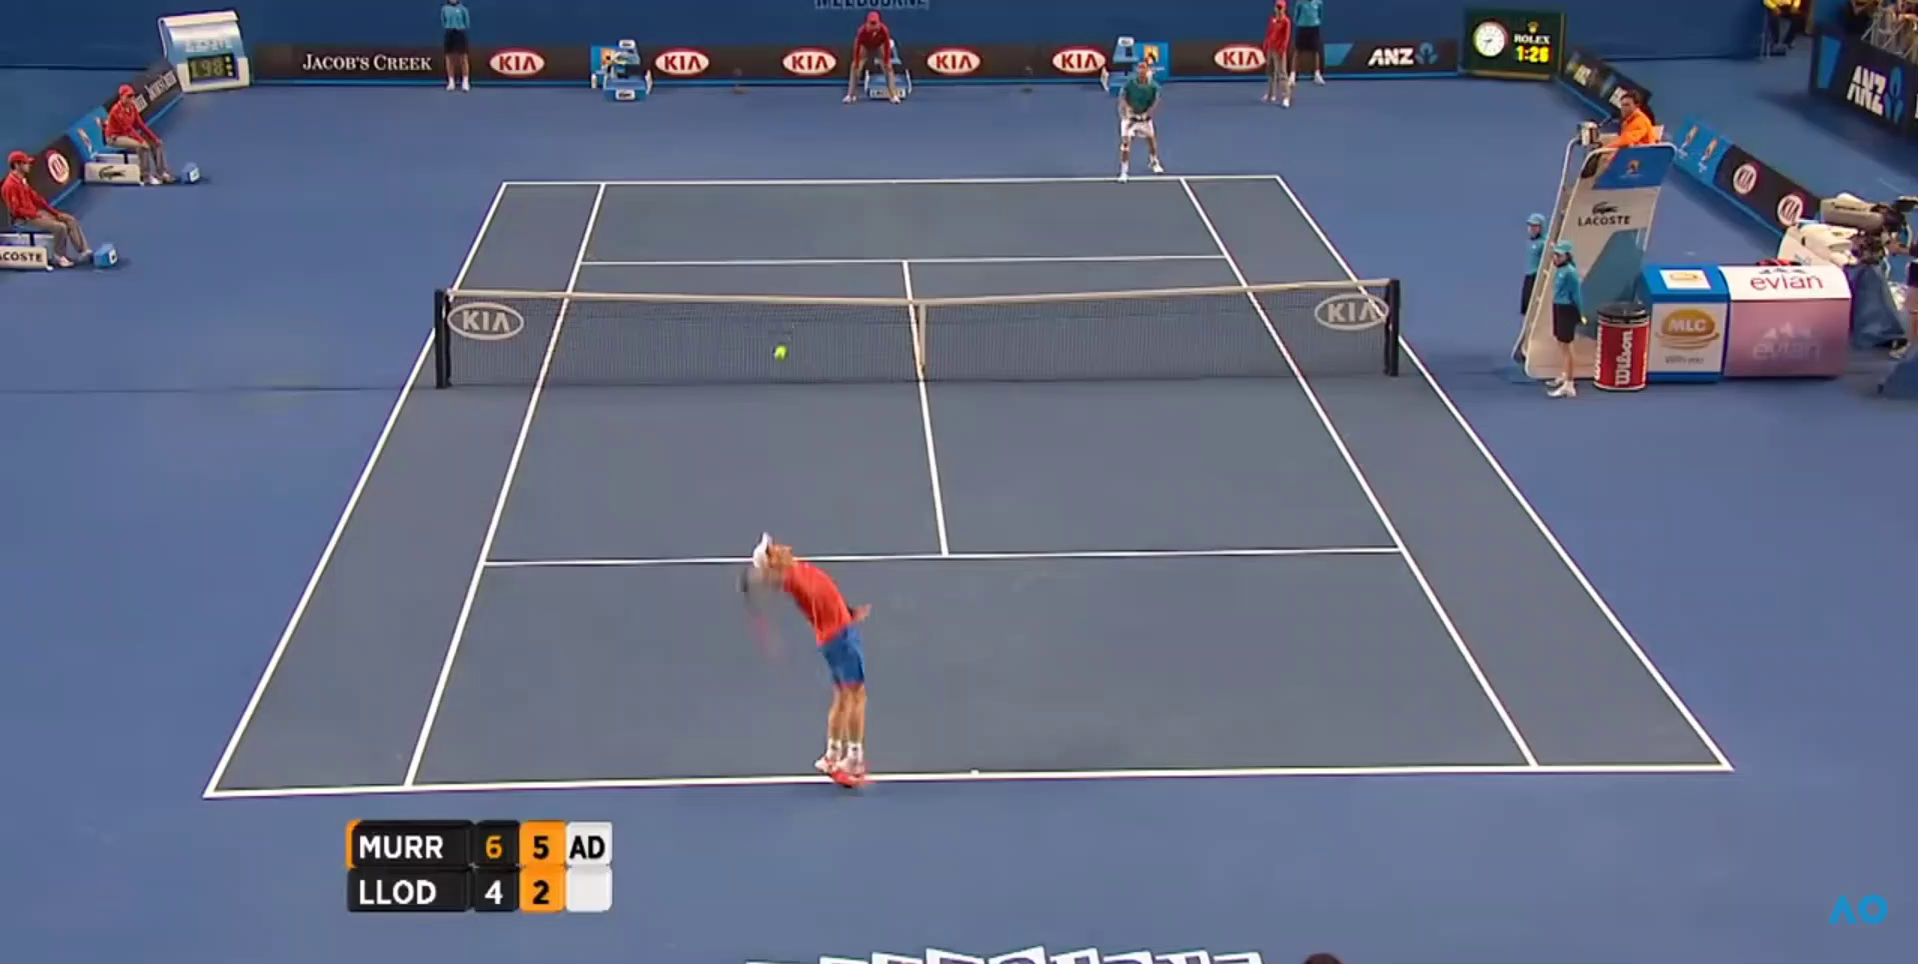

In [ ]:
ret, frame = cap.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
pilimg = Image.fromarray(frame)
pilimg

In [ ]:
# 对这一帧图像进行目标检测
detections = detect_image(pilimg)
detections

tensor([[164.6796, 216.8698, 191.5544, 274.2080,   0.9882,   0.9999,   0.0000],
        [240.5188, 111.2726, 253.1677, 140.6082,   0.9283,   0.9997,   0.0000],
        [167.5435, 177.2674, 171.0233, 180.6892,   0.9877,   0.9994,  32.0000]],
       device='cuda:0')

In [ ]:
# 读取图像大小等数据
img = np.array(pilimg)
pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
unpad_h = img_size - pad_y
unpad_w = img_size - pad_x

In [ ]:
# 通过updata函数更新目标轨迹
tracked_objects = mot_tracker.update(detections.cpu())
tracked_objects

array([[167.54348755, 177.26742557, 171.02328491, 180.68923946,
        249.        ,  32.        ],
       [240.51881411, 111.27262861, 253.16770933, 140.60823076,
        248.        ,   0.        ],
       [164.67958037, 216.86981158, 191.55442842, 274.20800824,
        247.        ,   0.        ]])

In [ ]:
# 检测出的物体的类别
unique_labels = detections[:, -1].cpu().unique()
unique_labels_number = list(map(lambda x:int(x),unique_labels.numpy().tolist()))
print("检测出的物体类别 ",list(map(lambda x:classes[x],unique_labels_number)))
n_cls_preds = len(unique_labels)
print("检测出的物体类别数 ",n_cls_preds)

检测出的物体类别  ['person', 'sports ball']
检测出的物体类别数  2


In [ ]:
i = 1
for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
  print(i)
  i = i+1
  box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
  box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
  y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
  x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

  # 设定检测框的颜色
  color = colors[int(obj_id) % len(colors)]
  color = [i * 255 for i in color]
  cls = classes[int(cls_pred)]
  print("检测的物体",cls)
  print("检测框的RGB颜色值",color)

  # 将检测框添加到图像上
  cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
  cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
  cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)


1
检测的物体 sports ball
检测框的RGB颜色值 [189.0, 158.0, 57.0]
2
检测的物体 person
检测框的RGB颜色值 [140.0, 109.0, 49.0]
3
检测的物体 person
检测框的RGB颜色值 [206.0, 219.0, 156.0]


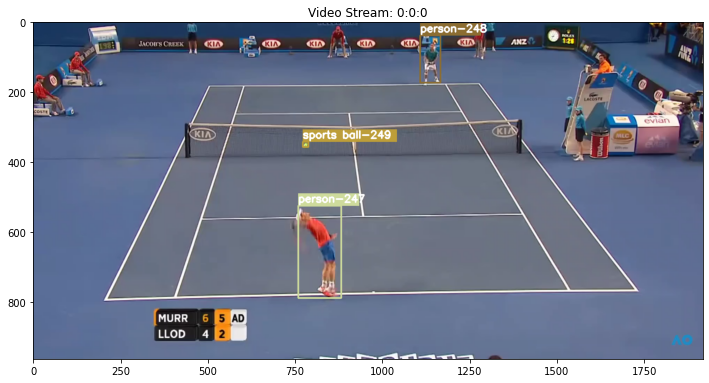

In [ ]:
fig = figure(figsize=(12, 8))
title("Video Stream")
imshow(frame)
title(f"Video Stream: {time_report}")
frame_img = Image.fromarray(frame)
show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


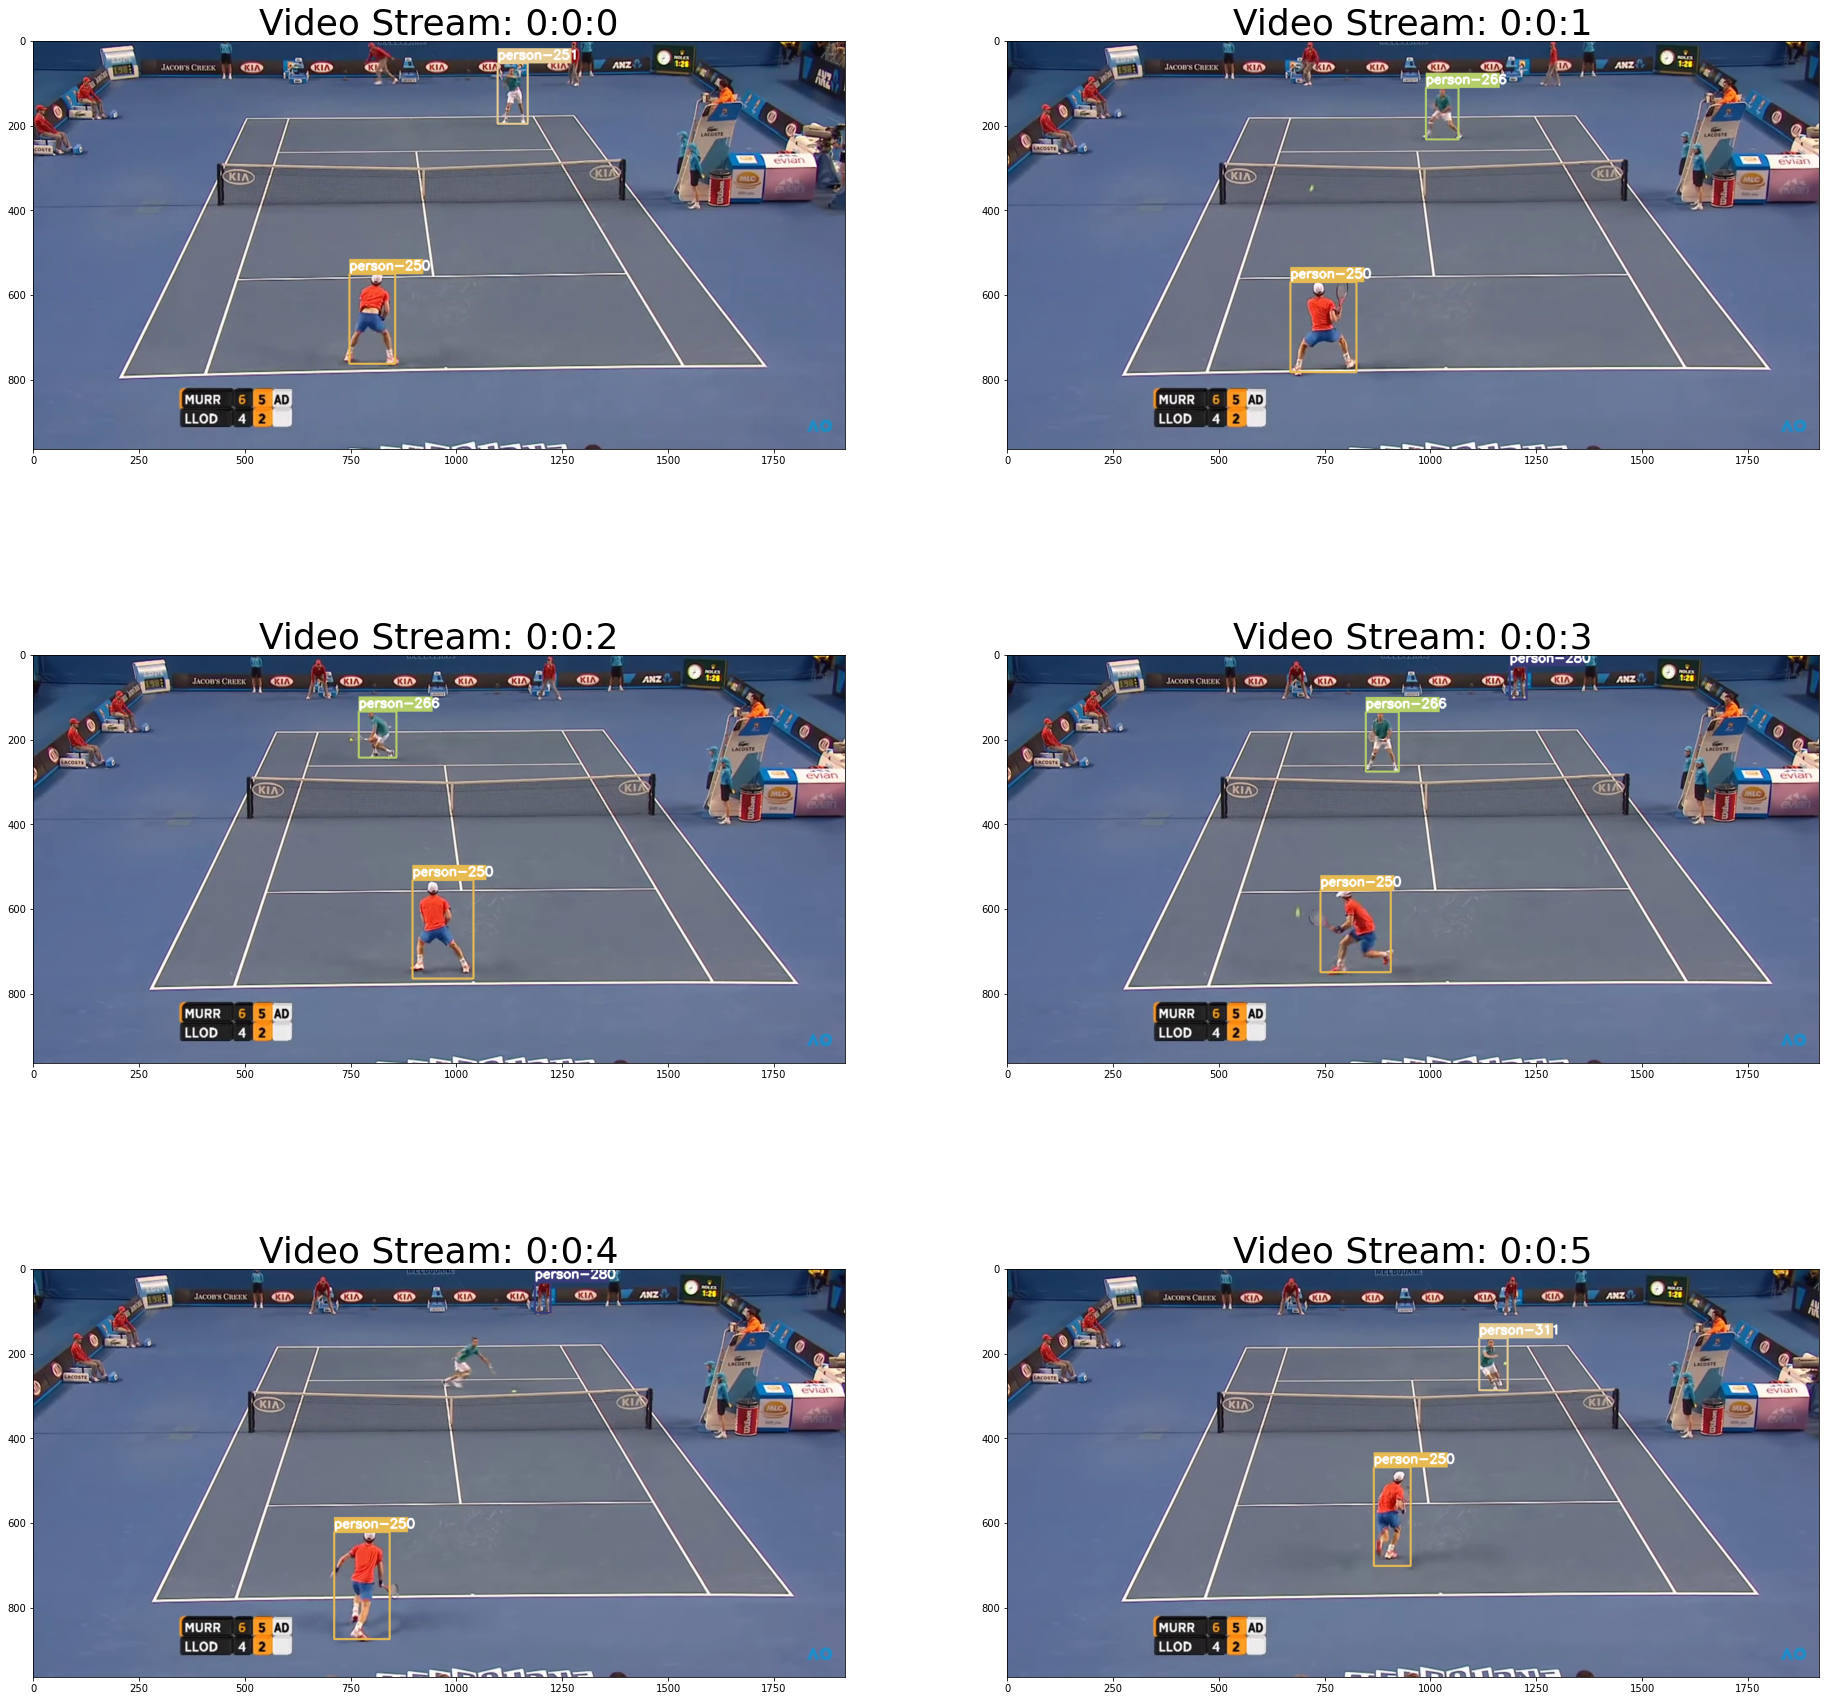

In [ ]:
# 读取视频数据
videopath = '/content/Tennis.mp4'
%pylab inline 
cmap = plt.get_cmap('tab20b')
# initialize Sort object and video capture
cap = cv2.VideoCapture(videopath)
mot_tracker = Sort() 
fig,ax = plt.subplots(nrows=3, ncols=2,figsize=(32,32))
subplot_number = 1
for ii in range(180):
    # 计算当前位置在视频中是多少毫秒
    timestamp = cap.get(cv2.CAP_PROP_POS_MSEC)
    time_report = convertMillis(timestamp)

    # vc.read()按帧读取视频
    # ret是布尔值，如果读取帧是正确的则返回True，如果文件读取到结尾，返回值就为False
    # frame是每一帧的图像，是一个三维矩阵
    ret, frame = cap.read()
    # 转换为RGB图像
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # 将这一帧图像展示出来
    pilimg = Image.fromarray(frame)
    detections = detect_image(pilimg)

    img = np.array(pilimg)
    pad_x = max(img.shape[0] - img.shape[1], 0) * (img_size / max(img.shape))
    pad_y = max(img.shape[1] - img.shape[0], 0) * (img_size / max(img.shape))
    unpad_h = img_size - pad_y
    unpad_w = img_size - pad_x
    if detections is not None:
        tracked_objects = mot_tracker.update(detections.cpu())

        unique_labels = detections[:, -1].cpu().unique()
        n_cls_preds = len(unique_labels)
        for x1, y1, x2, y2, obj_id, cls_pred in tracked_objects:
            box_h = int(((y2 - y1) / unpad_h) * img.shape[0])
            box_w = int(((x2 - x1) / unpad_w) * img.shape[1])
            y1 = int(((y1 - pad_y // 2) / unpad_h) * img.shape[0])
            x1 = int(((x1 - pad_x // 2) / unpad_w) * img.shape[1])

            color = colors[int(obj_id) % len(colors)]
            color = [i * 255 for i in color]
            cls = classes[int(cls_pred)]
            cv2.rectangle(frame, (x1, y1), (x1+box_w, y1+box_h), color, 4)
            cv2.rectangle(frame, (x1, y1-35), (x1+len(cls)*19+60, y1), color, -1)
            cv2.putText(frame, cls + "-" + str(int(obj_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 3)
    
    if (ii+1)%30 == 0:
      # fig = figure(figsize=(12, 8))
      plt.subplot(3, 2, subplot_number)
      subplot_number = subplot_number + 1
      title("Video Stream")
      imshow(frame)
      title(f"Video Stream: {time_report}", fontsize=36)

    
    frame_img = Image.fromarray(frame)
    frame_img_resize = frame_img.resize((512, 512))
    frame_img_resize.save(f"images/{ii:03d}.jpg")
   


In [ ]:
# 保存
import imageio

jpg_dir = '/content/object-tracking-SORT-Pytorch/images'
images = []
for file_name in sort(os.listdir(jpg_dir)):
    if file_name.endswith('.jpg'):
        file_path = os.path.join(jpg_dir, file_name)
        images.append(imageio.imread(file_path))

imageio.mimsave('/content/object-tracking-SORT-Pytorch/video/Tennis.gif', images, fps=55)